# Credit-Risk Modelling
<br>
data source: https://www.kaggle.com/c/home-credit-default-risk/

## Business Understanding

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful

# Data Understanding

The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

1. application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
<br>
2. bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
<br>
3. bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
<br>
4. previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
<br>
5. POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
<br>
6. credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
<br>
7. installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

## Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import math
import statistics

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

pd.options.display.max_rows = 1000

## Checking files that will be used

In [2]:
file_list = os.listdir('.')
print('The files that will be used are:' '\n')
for file in file_list:
    if '.csv' in file:
        print(file)

The files that will be used are:

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
sample_submission.csv


All file's content has been explained in the previous section, so lets continue to see the greater details! Firstly lets look into the **application_train.csv**

## Memory Optimization

In [3]:
def optimize(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if str(col_type)[:3] == 'int' or str(col_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min >= 0 and str(col_type)[:3] == 'int':
                if c_max < 255:
                    df[col] = df[col].astype(np.uint8)
                elif c_max < 65535:
                    df[col] = df[col].astype(np.uint16)
                elif c_max < 4294967295:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col].astype(np.uint64)            
            elif str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Reading the train data

In [4]:
train_data = optimize(pd.read_csv('application_train.csv',index_col='SK_ID_CURR'))
print('The size of train_data is:',train_data.shape)

Memory usage of dataframe is: 286.23 MB
Memory usage after optimization is: 129.33 MB
Decreased by 54.8%
The size of train_data is: (307511, 121)


## Information about the data

In [ ]:
# Checking data
display(train_data.head().T)

In [ ]:
#Basic statistics of data
display(train_data.describe().T)

In [ ]:
#Data types
train_data.dtypes

In [ ]:
#Checking name of columns
list(train_data)

In [ ]:
#Checking vull values in data and its proportion to each column
def missing_values_table(df):
    missing_value = df.isnull().sum()
    missing_value_percentage = 100 * df.isnull().sum() / len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percentage], axis=1)
    missing_value_table = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    missing_value_table = missing_value_table[missing_value_table.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1)
    return missing_value_table

missing_values_table(train_data)

## Exploratory Data Analysis

### Default & Non-default Clients Distribution

In [ ]:
sns.countplot(x='TARGET', data=train_data)

plt.xlabel('TARGET')
plt.ylabel('COUNT')
plt.title('DEFAULT CONTRACT DISTRIBUTION')
plt.show()

### Client's Age Distribution

In [ ]:
#For more intuitive sight, lets translate DAYS_BIRTH to AGE
train_data['AGE'] = train_data['DAYS_BIRTH'].apply(lambda x: math.floor(x/-365))

#Plotting distribution of Age who Defaulted
plt.style.use('bmh')
sns.kdeplot(train_data[train_data['TARGET'] == 1]['AGE'],color='red')
sns.kdeplot(train_data[train_data['TARGET'] == 0]['AGE'],color='blue')

### Contract Type Percentage

In [ ]:
fig, ax = plt.subplots()

size = 0.3
vals = train_data['NAME_CONTRACT_TYPE'].value_counts()
my_circle = plt.Circle((0,0), 0.7, color='white')
cmap = plt.get_cmap("tab20c")
labels = ['Cash loans','Revolving Loans']

ax.pie(vals, radius=1, startangle=90, wedgeprops={'edgecolor': 'black'}, 
       textprops={'fontsize': 14}, autopct='%1.f%%')
plt.gcf().gca().add_artist(my_circle)

fig.set_figheight(8)
fig.set_figwidth(6)
fig.legend(labels=labels, fontsize='large',loc='upper right',bbox_to_anchor=(0.5, 0.35, 0.7, 0.5))
fig.tight_layout()
fig.suptitle('Client Contact Information Provided', fontsize=25, y=0.9, fontweight='bold', x=0.5)

fig.savefig('Opinions_ctq')
plt.show()

### Client's Contact Provided

In [ ]:
plt.style.use('seaborn')

#Building dataframe consist of customers data provided
cols_list = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
count_value = pd.DataFrame(columns=cols_list,index=[0,1])

for col in cols_list:
    count_value[col]= train_data[col].value_counts().to_frame()
count_value = count_value.T

fig, ax = plt.subplots(nrows=3, ncols=2)

labels = 'No', 'Yes'
colors = ['#ff6666', '#ffcc99']

plt.title('Client Contact Information')
plt.tight_layout()

#Plotting pie chart for every data kind
chart_title = ['Mobile Phone','Work Phone','Office Phone','Phone Reachability','Home Phone','E-mail']

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].pie(count_value.iloc[2*i+j], startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, 
                    textprops={'fontsize': 14}, autopct='%1.f%%')
        ax[i,j].set_title(chart_title[2*i+j], fontweight='bold',fontsize= 18)

fig.suptitle('Client Contact Information Provided', fontsize=25, y=1.04, fontweight='bold', x=0.5)
fig.set_figheight(15)
fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='large',loc='upper right',bbox_to_anchor=(0.5, 0.52, 0.6, 0.5))
fig.tight_layout()

fig.savefig('Opinions_ctq')

plt.show()

## Client Registered Address

In [ ]:
plt.style.use('seaborn')

#Building dataframe consist of customers data provided
cols_list = ['REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY']
count_value = pd.DataFrame(columns=cols_list,index=[0,1])

for col in cols_list:
    count_value[col]= train_data[col].value_counts().to_frame()
count_value = count_value.T

fig, ax = plt.subplots(nrows=1, ncols=2)
a,b = [plt.cm.Blues,plt.cm.Reds]
labels = 'Yes', 'No'

#Plotting pie chart for every data kind
chart_title = ['Registered City = Living City','Registered City = Working City']
explode = (0,0.11)

for i in range(0,2):
    ax[i].pie(count_value.iloc[i], explode = explode, startangle=90, shadow= True, 
              colors=[a(0.7),b(0.7)], wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%',textprops={'fontsize': 14})
    ax[i].set_title(chart_title[i], fontweight='bold')
    
fig.suptitle('Client Registered Address', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='large',loc=1,bbox_to_anchor=(0.5, 0.4, 0.6, 0.5))
fig.tight_layout()

fig.savefig('Opinions_ctq')

plt.show()

### Client's Wealth

In [ ]:
plt.style.use('seaborn')

#Building dataframe consist of customers data provided
cols_list = ['FLAG_OWN_CAR','FLAG_OWN_REALTY']
count_value = pd.DataFrame(columns=cols_list,index=['Y','N'])

for col in cols_list:
    count_value[col]= train_data[col].value_counts().to_frame()
count_value = count_value.T

fig, ax = plt.subplots(nrows=1, ncols=2)
colors = ['#72DA51','#DADC53']
labels = 'Yes', 'No'

#Plotting pie chart for every data kind
chart_title = ['Own Car','Own House or Apartment']
explode = (0,0.11)

for i in range(0,2):
    ax[i].pie(count_value.iloc[i], explode = explode, startangle=90, shadow= True, colors=colors,
              wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%',textprops={'fontsize': 14})
    ax[i].set_title(chart_title[i], fontweight='bold',fontsize=15)
    
fig.suptitle('Client Wealth', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='large',loc=1,bbox_to_anchor=(0.5, 0.4, 0.6, 0.5))
fig.tight_layout()

fig.savefig('Opinions_ctq')

plt.show()

### Loan Specification

In [ ]:
plt.style.use('seaborn')

#Column to plot
cols_list = ['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

fig, ax = plt.subplots(nrows=1, ncols=3)

chart_title = ['Amount of Credit','Amount of Annuity', 'Amount of Goods Price']
labels = ['Default','No Default']

for i in range(0,3):
    ax[i].hist(train_data[train_data['TARGET'] == 1][cols_list[i]],bins=25,color='b',alpha=0.5)
    ax[i].hist(train_data[train_data['TARGET'] == 0][cols_list[i]],bins=25,color='r',alpha=0.5)
    ax[i].set_title(chart_title[i], fontweight='bold',fontsize=15)
    
fig.suptitle('Loan Specification', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(6)
fig.set_figwidth(15)
fig.tight_layout()
fig.legend(labels=labels,fontsize='medium',loc=1,bbox_to_anchor=(0.5, 0.4, 0.6, 0.5))

fig.savefig('Opinions_ctq')

plt.show()

### Previous Loan Specification 

In [ ]:
#Reading previous loan data
prev_loan = optimize(pd.read_csv('previous_application.csv',index_col='SK_ID_CURR'))

#People who have default loan and have historical loan
def_client = train_data[train_data['TARGET'] == 1].index.values
non_def_client = train_data[train_data['TARGET'] == 0].index.values
prev_loan_by_def_clients = prev_loan.iloc[def_client,:]
prev_loan_by_non_def_clients = prev_loan.iloc[non_def_client,:]
#prev_loan_by_def_clients.head(10)


plt.style.use('seaborn')
#Column to plot
cols_list = ['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

fig, ax = plt.subplots(nrows=1, ncols=3)

chart_title = ['Amount of Credit','Amount of Annuity', 'Amount of Goods Price']
labels = ['Default','No Default']

for i in range(0,3):
    ax[i].hist(prev_loan_by_def_clients[cols_list[i]],bins=25,color='b')
    ax[i].hist(prev_loan_by_non_def_clients[cols_list[i]],bins=25,color='r',alpha=0.5)
    ax[i].set_title(chart_title[i], fontweight='bold',fontsize=15)
    
fig.suptitle('Loan Specification', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(6)
fig.set_figwidth(15)
fig.tight_layout()
fig.legend(labels=labels,fontsize='medium',loc=1,bbox_to_anchor=(0.5, 0.4, 0.6, 0.5))

fig.savefig('Opinions_ctq')

plt.show()

### Conclusion on EDA

From the EDA step, we can conclude that:
<br>
1. Target class is highly imbalance
<br>
2. There is a trend where the client's age increasing, the probability of client defaulted decreasing
<br>
3. Most of the loans are cash loans
<br>
4. Almost all clients provide mobile phone and the phone numbers are reachable.
<br>
5. Clients registered address are mostly in the same city where they live, but not where their work
<br>
6. Two-third of clients don't have their own car, but two-third of them have their own home
<br>
7. Loan specification such as amount loan total, amount annuity, etc does'nt show any trend which refer to the defaulted contracts

## Data Preparation

### Encoding Categorical Feature

In [5]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# Instantiate both packages to use
encoder = OrdinalEncoder()

# Create a list of categorical columns to iterate over
category_cols = [col for col in list(train_data) if train_data[col].dtype  == 'object']

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

# Create a for loop to iterate through each column in the data
for col in category_cols:
    encode(train_data[col])

### Anomaly Detection and Treatment

All continuous columns has been scaled, so we will assume no anomaly in the columns. Next we will check on discrete columns

In [ ]:
# List all columns that consist of discrete numbers 
flag_columns = [col for col in list(train_data) if 'FLAG_' in col]
reg_columns = [col for col in list(train_data) if '_REGION' in col]
city_columns = [col for col in list(train_data) if '_CITY' in col]
amt_columns = [col for col in list(train_data) if 'AMT_' in col]
reg_rating_columns = [col for col in list(train_data) if 'REGION_RATING' in col]
soc_circle_columns = [col for col in list(train_data) if 'SOCIAL_CIRCLE' in col]
days_columns = [col for col in list(train_data) if 'DAYS_' in col]
other_disc_columns = ['CNT_CHILDREN','OWN_CAR_AGE','CNT_CHILDREN','CNT_FAM_MEMBERS','HOUR_APPR_PROCESS_START']
all_discrete_columns = category_cols + flag_columns + reg_columns + city_columns + amt_columns + reg_rating_columns + soc_circle_columns + days_columns + other_disc_columns

#Plotting distribution of cnt columns
plt.style.use('seaborn')

#Column to plot (except flag-type columns and rating columns)
cols_list = amt_columns+soc_circle_columns+days_columns+other_disc_columns

fig, ax = plt.subplots(nrows=8, ncols=3)

for i in range(0,8):
    for j in range(0,3):
        ax[i,j].hist(train_data[cols_list[3*i+j]],bins=50,color='b',alpha=0.5)
        ax[i,j].set_title(cols_list[3*i+j], fontweight='bold',fontsize=15)
    
fig.suptitle('Loan Specification', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(30)
fig.set_figwidth(11)
fig.tight_layout()

fig.savefig('Opinions_ctq')

plt.show()

Anomaly spotted in AMT_INCOME_TOTAL and DAYS_EMPLOYED. The data will be filled by nan and will be imputed in the next step

In [ ]:
# Drop data for AMT_INCOME_TOTAL > 100000000
train_data['AMT_INCOME_TOTAL'] = train_data['AMT_INCOME_TOTAL'].apply(lambda x: np.nan if x > 100000000 else x)

# Drop data for DAYS_EMPLOYED > 0
train_data['DAYS_EMPLOYED'] = train_data['DAYS_EMPLOYED'].apply(lambda x: np.nan if x > 0 else x)

### Data Imputation 

In [ ]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [ ]:
# Defining imputation by MICE method function
def impute_MICE(df):
    df_columns = df.columns
    imp_mean = IterativeImputer(initial_strategy = "mean", n_nearest_features = 15, random_state = 0, imputation_order="ascending")
    x = imp_mean.fit(df)
    X = df
    df_MICE_imputed = pd.DataFrame(imp_mean.transform(X),index=df.index)
    df_MICE_imputed.columns = df_columns
    return df_MICE_imputed

In [ ]:
# Change data type to float for imputation preparation
for col in list(train_data):
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].astype(float)

# Exclude 'TARGET' from train_data to prevent data leakage
imputation_data = train_data.drop('TARGET',axis=1)

# Imputing train data, (mice function only accept np.array data) and format it to dataframe
imputing_train = impute_MICE(imputation_data)
imputed_train = pd.DataFrame(imputing_train, columns=imputation_data.columns)

In [ ]:
# Checking if there is still any missing values in imputed data
missing_values_table(imputed_train)

#The result must be empty after imputation process

In [ ]:
# Rounding numbers in columns that are discrete
imputed_train[all_discrete_columns] = np.round(imputed_train[all_discrete_columns])

In [ ]:
# Concat with TARGET to get final imputed_train
final_imputed_train = pd.merge(left=imputed_train.reset_index(), right=train_data['TARGET'].reset_index(), on='SK_ID_CURR')
final_imputed_train = final_imputed_train.set_index('SK_ID_CURR')

# Saving final_imputed_train
final_imputed_train.to_csv('./output-files/final_imputed_train.csv')

In [9]:
# Read final_imputed_train file
final_imputed_train = optimize(pd.read_csv('./output-files/final_imputed_train.csv',index_col='SK_ID_CURR'))
display(final_imputed_train.head())

Memory usage of dataframe is: 288.57 MB
Memory usage after optimization is: 144.58 MB
Decreased by 49.9%


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,1.0,0.0,1.0,0.0,202500.0,406598.0,24700.0,351000.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0,1
100003,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.0,35698.0,1129500.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0
100004,1.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0
100006,0.0,0.0,0.0,1.0,0.0,135000.0,312682.0,29686.0,297000.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,52.0,0
100007,0.0,1.0,0.0,1.0,0.0,121500.0,513000.0,21866.0,513000.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0


### Balancing Classes Using SMOTE

In [22]:
# Import libraries needed
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

In [49]:
# Define dataset
X = final_imputed_train.drop('TARGET',axis=1)
y = final_imputed_train['TARGET']

# Searching optimum k_neighbors for oversample minority data using RepeatedStratifiedKfold
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = LogisticRegression()
    over = SMOTE(sampling_strategy=0.5, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5,random_state=101)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    k_score['score'] = score
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.634
> k=2, Mean ROC AUC: 0.634
> k=3, Mean ROC AUC: 0.634
> k=4, Mean ROC AUC: 0.635
> k=5, Mean ROC AUC: 0.634
> k=6, Mean ROC AUC: 0.634
> k=7, Mean ROC AUC: 0.634


In [59]:
# Finding optimum oversample and undersample strategy that gives maximum score
oversample_strategy = [0.1, 0.2, 0.3, 0.4, 0.5]
undersample_strategy = [0.9, 0.8, 0.7, 0.6, 0.5]

for i in oversample_strategy:
    for j in undersample_strategy:
        model = LogisticRegression()
        over = SMOTE(sampling_strategy=i, k_neighbors=4)
        under = RandomUnderSampler(sampling_strategy=j,random_state=101)
        steps = [('over', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)
        # evaluate pipeline
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        score = mean(scores)
        print('> i=%.1f, j=%.1f, Mean ROC AUC: %.3f' % (i,j, score))      

> i=0.1, j=0.9, Mean ROC AUC: 0.623
> i=0.1, j=0.8, Mean ROC AUC: 0.626
> i=0.1, j=0.7, Mean ROC AUC: 0.630
> i=0.1, j=0.6, Mean ROC AUC: 0.633
> i=0.1, j=0.5, Mean ROC AUC: 0.635
> i=0.2, j=0.9, Mean ROC AUC: 0.622
> i=0.2, j=0.8, Mean ROC AUC: 0.626
> i=0.2, j=0.7, Mean ROC AUC: 0.629
> i=0.2, j=0.6, Mean ROC AUC: 0.632
> i=0.2, j=0.5, Mean ROC AUC: 0.635
> i=0.3, j=0.9, Mean ROC AUC: 0.622
> i=0.3, j=0.8, Mean ROC AUC: 0.626
> i=0.3, j=0.7, Mean ROC AUC: 0.629
> i=0.3, j=0.6, Mean ROC AUC: 0.632
> i=0.3, j=0.5, Mean ROC AUC: 0.635
> i=0.4, j=0.9, Mean ROC AUC: 0.622
> i=0.4, j=0.8, Mean ROC AUC: 0.625
> i=0.4, j=0.7, Mean ROC AUC: 0.629
> i=0.4, j=0.6, Mean ROC AUC: 0.632
> i=0.4, j=0.5, Mean ROC AUC: 0.634
> i=0.5, j=0.9, Mean ROC AUC: 0.622
> i=0.5, j=0.8, Mean ROC AUC: 0.625
> i=0.5, j=0.7, Mean ROC AUC: 0.629
> i=0.5, j=0.6, Mean ROC AUC: 0.632
> i=0.5, j=0.5, Mean ROC AUC: 0.634


In [12]:
# Transforming dataset with optimum parameters (k_neighbors, oversample strategy, undersample strategy) obtained
over = SMOTE(sampling_strategy=0.3, k_neighbors=2)
under = RandomUnderSampler(sampling_strategy=0.4,random_state=101)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X = final_imputed_train.drop('TARGET',axis=1)
y = final_imputed_train['TARGET']
X, y = pipeline.fit_resample(X, y)

<AxesSubplot:xlabel='TARGET', ylabel='count'>

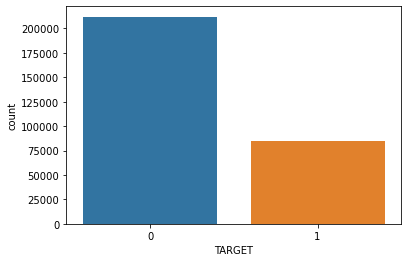

In [13]:
# Checking target class proportion after rebalancing
sns.countplot(x=y)

### Regularization (Lasso Regression)

In [14]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
prediction=pd.DataFrame()

X = final_imputed_train.drop('TARGET',axis=1)
y = final_imputed_train['TARGET']
clf = Lasso(alpha=0.005)
scaler = StandardScaler()
clf.fit(scaler.fit_transform(X), y)

final_features = []
for i in range(len(list(X))):
    if clf.coef_[i]:
        final_features.append(list(X)[i])

print('The features that will be used are', final_features)

The features that will be used are ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3']


In [15]:
# List of final features used in model
final_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'NAME_EDUCATION_TYPE',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_3']

In [16]:
# Updating train data set
final_train = pd.concat([X[final_features],y],axis=1)
final_train.to_csv('./output-files/final_train.csv')

In [17]:
# Reading final_train dataset that will be used in modelling
final_train = optimize(pd.read_csv('./output-files/final_train.csv'))
display(final_train.head())

Memory usage of dataframe is: 30.50 MB
Memory usage after optimization is: 14.37 MB
Decreased by 52.9%


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_3,TARGET
0,100002,0.0,1.0,0.0,4.0,-637.0,2.0,0.083037,0.262949,0.139376,2.0,1.0,1
1,100003,0.0,0.0,0.0,1.0,-1188.0,1.0,0.311267,0.622246,0.514970,0.0,1.0,0
2,100004,1.0,1.0,1.0,4.0,-225.0,2.0,0.621678,0.555912,0.729567,0.0,0.0,0
3,100006,0.0,0.0,0.0,4.0,-3039.0,2.0,0.627003,0.650442,0.542843,0.0,1.0,0
4,100007,0.0,1.0,0.0,4.0,-3038.0,2.0,0.627377,0.322738,0.544202,0.0,0.0,0


## Data Modelling

### Train-test Split Data

In [18]:
X = final_train.drop('TARGET',axis=1)
y = final_train['TARGET']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train shape:', X_train.shape,'\n'
      'X_test shape:', X_test.shape,'\n'
      'y_train shape:', y_train.shape,'\n'
      'y_test shape:', y_test.shape)

X_train shape: (215257, 12) 
X_test shape: (92254, 12) 
y_train shape: (215257,) 
y_test shape: (92254,)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(scaler.fit_transform(X_train),y_train)
prediction = log_reg.predict_proba(scaler.fit_transform(X_train))
prediction[:,1]

array([0.06741572, 0.0251509 , 0.03790187, ..., 0.03235917, 0.05932293,
       0.14889962])

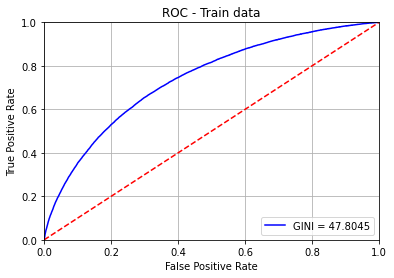

Gini = 47.8045
AUC = 0.7390224256299602


In [20]:
# logit_roc_auc = roc_auc_score(y_train.values, pred)
logit_roc_auc = roc_auc_score(y_train, prediction[:,1])
fpr, tpr, thresholds = roc_curve(y_train, prediction[:,1])

plt.figure()
gini = 2*(logit_roc_auc-0.5)*100
plt.plot(fpr, tpr,'b', label='GINI = %0.4f' % gini)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Train data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_TRAIN')
plt.grid()
plt.show() 

print('Gini = %0.4f'% gini)
print('AUC =',logit_roc_auc)

In [ ]:
scaler

# Reference

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html<br>
https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499 <br>
https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8 <br>
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114 <br>
https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b <br>
https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2 <br>
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ <br>
https://machinelearningmastery.com/calculate-feature-importance-with-python/ <br>
Buuren, Oudshoorn.2011.mice: Multivariate Imputation by Chained Equations in R.*Jurnal of Statistical Software*.45(3) <br>
